In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
from biaplotter.artists import CustomScatter, AbstractArtist
from nap_plot_tools.cmap import cat10_mod_cmap

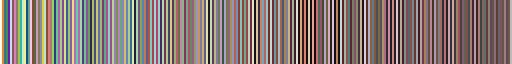

In [2]:
cat10_mod_cmap

In [13]:
class Custom2DHistogram(AbstractArtist):
    def __init__(self, data: np.ndarray = None, ax: plt.Axes = None, colormap: Colormap = cat10_mod_cmap, color_indices: np.ndarray = None, bins=10, histogram_colormap: Colormap = plt.cm.viridis):
        super().__init__(data, ax, colormap, color_indices)
        self._histogram = None  # Placeholder for the 2D histogram artist
        self._bins = bins  # Number of bins for the histogram
        self._histogram_colormap = histogram_colormap  # Colormap for the histogram
        self.data = data  # Initialize the histogram with data
        self.draw()  # Initial draw of the histogram

    @property
    def data(self) -> np.ndarray:
        """Returns the data associated with the 2D histogram."""
        return self._data

    @data.setter
    def data(self, value: np.ndarray):
        """Sets the data for the 2D histogram, updating the display as needed."""
        if value is None or len(value) == 0:
            return
        self._data = value
        # Remove the existing histogram to redraw
        if self._histogram is not None:
            for artist in self._histogram[-1]:
                artist.remove()
        # Draw the new histogram
        self._histogram = self._ax.hist2d(value[:, 0], value[:, 1], bins=self._bins, cmap=self._histogram_colormap, zorder=1)
        self.draw()

    @property
    def visible(self) -> bool:
        """Determines if the 2D histogram is currently visible."""
        return self._visible

    @visible.setter
    def visible(self, value: bool):
        """Sets the visibility of the 2D histogram."""
        self._visible = value
        if self._histogram is not None:
            for artist in self._histogram[-1]:
                artist.set_visible(value)
        self.draw()

    @property
    def color_indices(self) -> np.ndarray:
        # This property might be less relevant for histograms, as color mapping is often handled differently
        return self._color_indices

    @color_indices.setter
    def color_indices(self, indices: np.ndarray):
        
        self._color_indices = indices
        h, xedges, yedges, _ = self._histogram
         # Create empty overlay
        overlay_rgba = np.zeros((*h.shape, 4), dtype=float)
        output_max = np.zeros(h.shape, dtype=float)
        for i in np.unique(self._color_indices):
            # Filter data by class
            data_filtered_by_class = self._data[self._color_indices == i]
            print(data_filtered_by_class.shape)
            # Calculate histogram of filtered data while fixing the bins
            histogram_filtered_by_class, _, _ = np.histogram2d(data_filtered_by_class[:, 0], data_filtered_by_class[:, 1], bins=[xedges, yedges])
            class_mask = histogram_filtered_by_class > output_max
            output_max = np.maximum(histogram_filtered_by_class, output_max)
            # Get current class color and make it half transparent
            # current_color = self._colormap(i)
            # current_color_array = np.array(current_color)
            # current_color_array[-1] = 0.5
            # current_color = tuple(current_color_array)
            overlay_rgba[class_mask] = self._colormap(i)
        # Draw the overlay
        self._ax.imshow(overlay_rgba.swapaxes(0, 1), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', alpha=1, zorder=2)
        self.draw()

    def draw(self):
        """Draws or redraws the 2D histogram."""
        self._ax.figure.canvas.draw_idle()

In [14]:


# Generate some random data4
np.random.seed(42)  # For reproducible results
data = np.random.randn(100, 2)  # 100 2D points

# Setup the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Create and display a CustomScatterArtist
scatter_artist = CustomScatter(ax=axs[0])
axs[0].set_title('Custom Scatter Plot')

# Create and display a Custom2DHistogramArtist
histogram_artist = Custom2DHistogram(data=data, ax=axs[1], bins=20, histogram_colormap=plt.cm.plasma)
axs[1].set_title('Custom 2D Histogram')

# # Display the initial plots
plt.show()



In [15]:
scatter_artist.data = data  # Update data for the CustomScatterArtist

In [16]:
# Update color_indices for both artists to change colors
color_indices = np.linspace(1, 6, 100).astype(int)

# Update and display changes for the CustomScatterArtist
scatter_artist.color_indices = color_indices[:data.shape[0]]  # Assuming one color per point

In [17]:
# Update and display changes for the Custom2DHistogramArtist
histogram_artist.color_indices = color_indices  # Use same indices for simplicity

# After updating color_indices, the figures should be redrawn to show changes
# Since draw_idle is called within the setter, the plots will update automatically.

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(19, 2)
(1, 2)


Test for painting histogram

In [7]:
# Get histogram
h, xedges, yedges, image = histogram_artist._histogram
# Get data
data = histogram_artist._data

In [12]:
rgba_list = []


for i in np.unique(histogram_artist.color_indices):

    # Create empty overlay
    overlay_rgba = np.zeros((*h.shape, 4), dtype=float)
    output_max = np.zeros(h.shape, dtype=float)

    # Filter data by class
    data_filtered_by_class = data[histogram_artist.color_indices == i]
    print(data_filtered_by_class.shape)
    # Calculate histogram of filtered data while fixing the bins
    histogram_filtered_by_class, _, _ = np.histogram2d(data_filtered_by_class[:, 0], data_filtered_by_class[:, 1], bins=[xedges, yedges])
    class_mask = histogram_filtered_by_class > output_max
    output_max = np.maximum(histogram_filtered_by_class, output_max)
    # Get current class color and make it half transparent
    current_color = histogram_artist._colormap(i)
    current_color_array = np.array(current_color)
    current_color_array[-1] = 0.5
    current_color = tuple(current_color_array)
    overlay_rgba[class_mask] = histogram_artist._colormap(i)
    rgba_list.append(overlay_rgba)


(20, 2)
(20, 2)
(20, 2)
(20, 2)
(19, 2)
(1, 2)


In [10]:
overlay_rgba.shape

(20, 20, 4)

In [20]:
# clear axs[2]
axs[2].cla()

In [19]:
for overlay in rgba_list:
    axs[2].imshow(overlay.swapaxes(0, 1), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', alpha=0.5)
# Set bounds same to scatter
axs[2].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())

(-2.2229558186604184, 2.9555560706491444)

In [21]:
 # Create empty overlay
overlay_rgba = np.zeros((*h.shape, 4), dtype=float)
output_max = np.zeros(h.shape, dtype=float)
for i in np.unique(histogram_artist.color_indices):
    # Filter data by class
    data_filtered_by_class = data[histogram_artist.color_indices == i]
    print(data_filtered_by_class.shape)
    # Calculate histogram of filtered data while fixing the bins
    histogram_filtered_by_class, _, _ = np.histogram2d(data_filtered_by_class[:, 0], data_filtered_by_class[:, 1], bins=[xedges, yedges])
    class_mask = histogram_filtered_by_class > output_max
    output_max = np.maximum(histogram_filtered_by_class, output_max)
    # Get current class color and make it half transparent
    current_color = histogram_artist._colormap(i)
    current_color_array = np.array(current_color)
    current_color_array[-1] = 0.5
    current_color = tuple(current_color_array)
    overlay_rgba[class_mask] = histogram_artist._colormap(i)

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(19, 2)
(1, 2)


In [22]:
axs[2].imshow(overlay_rgba.swapaxes(0, 1), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', origin='lower', alpha=0.5)

In [14]:
output_max = np.zeros(h.shape, dtype=float)
output_max

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [ ]:
h2, _, _ = np.histogram2d(
            entries[feature_x], entries[feature_y], bins=[xedges, yedges]
        )
        

In [ ]:
mask = h2 > output_max